In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Functions needed for Data Preprocessing
from data import ( preprocess_stock_data,
                  clean_financial_ratios,
                  merge_and_clean_data,
                  filter_useful_features,
                  calculate_technical_indicators,
                  normalize_data,
                  merge_macro_data)

# import helper functions to run LSTM Training and Predictions
from helper import (create_df_per_stock,
                    run_for_stocks,
                    get_best_configuration,
                    final_df_cleaning,
                    create_return_arrays,
                    create_returns_for_cov, 
                    calculate_covariance_matrix)

# Load Dataset

In [2]:
# Load Data
stock = pd.read_csv('../data/stocks_1.csv')
stock_factor = pd.read_csv('../data/ratios_2.csv')
macro = pd.read_csv('../data/bond_and_cpi.csv')

In [3]:
# Select stocks
stock_avg = preprocess_stock_data(stock)
# Clean financial ratios data
stock_factor_1 = clean_financial_ratios(stock_avg, stock_factor)
# Merge trading data and financial ratios data and select proper companies
stock_all_final = merge_and_clean_data(stock_avg, stock_factor_1)
# Select features that are meaningful and useful
stock_final = filter_useful_features(stock_all_final)
# Calculate momentum technical indicators
stock_final_1 = stock_final.groupby('gvkey').apply(calculate_technical_indicators).reset_index(drop=True)
stock_use = stock_final_1.dropna()
# Merge macro data
stock_use = merge_macro_data(stock_use, macro)
# Normalization
stock_n = normalize_data(stock_use)
# Save to CSV
stock_n.to_csv('../data/normalized_data.csv', index=False)

C:\Users\kangj\AppData\Local\Temp\ipykernel_9396\2538610639.py:10: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  stock_final_1 = stock_final.groupby('gvkey').apply(calculate_technical_indicators).reset_index(drop=True)


In [4]:
# Save unnormalized returns
unnormalized_returns = stock_use[["datadate", "tic", "trt1m"]] 
unnormalized_returns

,datadate,tic,trt1m
0,2011-03-31,AVY,0.051102
1,2011-04-30,AVY,-0.005243
2,2011-05-31,AVY,0.020364
3,2011-06-30,AVY,-0.087624
4,2011-07-31,AVY,-0.183277
...,...,...,...
6463,2023-08-31,CBRE,0.020886
6464,2023-09-30,CBRE,-0.131570
6465,2023-10-31,CBRE,-0.061197
6466,2023-11-30,CBRE,0.138737


In [5]:
data = pd.read_csv("../data/normalized_data.csv") # Load Dataset from File generated previously. 
data = final_df_cleaning(data) # Drop unnecessary columns and arrange data by ticker and dates
tickers = data['tic'].unique() # Create a List of the Unique Stock Tickers
data.head()

,index,datadate,tic,cshtrm,prccm,prchm,prclm,trt1m,CAPEI,evm,...,b30ret,b20ret,b10ret,b7ret,b5ret,b2ret,b1ret,t90ret,t30ret,cpiret
0,3388,2011-03-31,AMZN,0.057669,0.050441,0.047726,0.048270,0.449252,0.657229,0.104348,...,0.447572,0.505968,0.485734,0.460448,0.479048,0.409137,0.349846,0.074603,0.021886,0.009751
1,3389,2011-04-30,AMZN,0.055855,0.054863,0.052030,0.052741,0.479247,0.657454,0.104348,...,0.524495,0.625134,0.632978,0.696662,0.777043,0.612828,0.390447,0.068691,0.018939,0.006439
2,3390,2011-05-31,AMZN,0.051408,0.055111,0.054307,0.057432,0.427200,0.657571,0.104227,...,0.577259,0.700208,0.734779,0.755825,0.762814,0.561705,0.414261,0.039340,0.010522,0.004704
3,3391,2011-06-30,AMZN,0.046094,0.057310,0.054270,0.054622,0.449368,0.657700,0.104227,...,0.352766,0.407129,0.432365,0.440776,0.524773,0.489151,0.358103,0.047289,0.015152,-0.001071
4,3392,2011-07-31,AMZN,0.044648,0.062395,0.059825,0.061283,0.479955,0.657969,0.104227,...,0.624880,0.760939,0.794987,0.803837,0.839120,0.529782,0.281747,0.009376,0.001894,0.000886


In [6]:
tickers

array(['AMZN', 'AVY', 'AXON', 'BBWI', 'BKNG', 'BLDR', 'CBRE', 'CDNS',
       'CE', 'CF', 'CHD', 'CMCSA', 'CMS', 'CNC', 'COST', 'DECK', 'DLTR',
       'EA', 'EQIX', 'FI', 'FICO', 'GOOGL', 'INCY', 'LULU', 'MA', 'MOH',
       'NDAQ', 'NI', 'NVDA', 'ODFL', 'OKE', 'PKG', 'SBAC', 'STLD', 'TDG',
       'TGT', 'TYL', 'UNH', 'URI', 'V', 'VLO', 'WST'], dtype=object)

In [7]:
# Dictionary to hold dataframe for each stock
df_per_stock = create_df_per_stock(tickers=tickers, dataframe=data)

D:\hey\ic\term3\Big Data in Finance II\BDF2\LSTM_based_Portfolio_Optimization\LSTM_based_Portfolio_Optimization\src\helper.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trt1m'] = df['trt1m'].shift(-1) # Shift Target Return up


In [8]:
df_per_stock

{'AMZN':      index    datadate   tic    cshtrm     prccm     prchm     prclm  \
 0     3388  2011-03-31  AMZN  0.057669  0.050441  0.047726  0.048270   
 1     3389  2011-04-30  AMZN  0.055855  0.054863  0.052030  0.052741   
 2     3390  2011-05-31  AMZN  0.051408  0.055111  0.054307  0.057432   
 3     3391  2011-06-30  AMZN  0.046094  0.057310  0.054270  0.054622   
 4     3392  2011-07-31  AMZN  0.044648  0.062395  0.059825  0.061283   
 ..     ...         ...   ...       ...       ...       ...       ...   
 148   3536  2023-07-31  AMZN  0.518922  0.037341  0.035816  0.037782   
 149   3537  2023-08-31  AMZN  0.591768  0.038562  0.037667  0.037931   
 150   3538  2023-09-30  AMZN  0.548020  0.035491  0.038258  0.036912   
 151   3539  2023-10-31  AMZN  0.596200  0.037175  0.035241  0.035493   
 152   3540  2023-11-30  AMZN  0.503032  0.040841  0.039159  0.040140   
 
         trt1m     CAPEI       evm  ...    b30ret    b20ret    b10ret  \
 0    0.479247  0.657229  0.104348  ...  

# Hyperparameter Tuning for LSTMs and Return Predictions

In [15]:
# Test with small list
param_grid = {
    'lstm_units': [100, 150],
    'dense_units1': [50, 100, 150],
    'dense_units2': [50, 75],
    'batch_size': [32, 64],
    'optimizer': ['adam'],
    'dropout_rate': [0.2, 0.3, 0.4],
    'regularization_value': [0.01, 0.001, 0.0001]
}

In [16]:
# Only Run the below command when running a new model - otherwise use the saved data within the 
# past_results folder

#models = run_for_stocks(tickers, df_per_stock, param_grid)

In [17]:
# Get Best Configuration for each stock via the CSV files
# Only run when you've finished running a new model above to confirm all best_configurations are saved
# Otherwise use best_configs inside the past_results folder
"""
best_configurations = get_best_configuration(tickers=tickers)
best_configurations_df = pd.DataFrame(best_configurations).T.reset_index()
best_configurations_df.columns = ['ticker',
                                  'lstm_units',
                                  'dense_units1',
                                  'dense_units2',
                                  'batch_size',
                                  'optimizer', 
                                  'avg_val_mse']
best_configurations_df
best_configurations_df.to_csv("../results/best_configs.csv")
"""

'\nbest_configurations = get_best_configuration(tickers=tickers)\nbest_configurations_df = pd.DataFrame(best_configurations).T.reset_index()\nbest_configurations_df.columns = [\'ticker\',\n                                  \'lstm_units\',\n                                  \'dense_units1\',\n                                  \'dense_units2\',\n                                  \'batch_size\',\n                                  \'optimizer\', \n                                  \'avg_val_mse\']\nbest_configurations_df\nbest_configurations_df.to_csv("../results/best_configs.csv")\n'

In [9]:
# Create a Numpy Array of Returns
without_macro_features = "../past_results/without_macro_data/"
with_macro_features = "../past_results/with_macro_data/"

default_lstm_no_burning_window_12m = create_return_arrays(tickers=tickers,
                                                          folder=f"{without_macro_features}default_lstm_no_burning_window_12m")
default_lstm_with_burning_window_12m = create_return_arrays(tickers=tickers,
                                                            folder=f"{without_macro_features}default_lstm_burning_window_12m")
default_lstm_no_burning_window_3m = create_return_arrays(tickers=tickers,
                                                         folder=f"{without_macro_features}default_lstm_no_burning_window_3m")
default_lstm_with_burning_window_3m = create_return_arrays(tickers=tickers,
                                                            folder=f"{without_macro_features}default_lstm_with_burning_window_3m")
default_lstm_with_burning_window_6m = create_return_arrays(tickers=tickers,
                                                           folder=f"{without_macro_features}default_lstm_burning_window_6m")

# Covariance Matrix via Shrinkage

In [10]:
# Each List below stores Matrix of Returns with Past Returns + Next Month's Return Predictions for each Month

returns_data_12m_no_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_no_burning_window_12m)

returns_data_12m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_12m)

returns_data_3m_no_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_no_burning_window_3m)

returns_data_3m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_3m)

returns_data_6m_with_burning_window = create_returns_for_cov(df_per_stock=df_per_stock,
                                      return_array=default_lstm_with_burning_window_6m)

In [11]:
# Each List  below stores a 42 x 42 Covariance Matrix for each out of sample period for the relevant sequence size for each Month

cov_matrices_12m_no_burning_window, shrinkages_12m_no_burning_window = calculate_covariance_matrix(returns_data_12m_no_burning_window)

cov_matrices_12m_with_burning_window, shrinkages_12m_with_burning_window = calculate_covariance_matrix(returns_data_12m_with_burning_window)

cov_matrices_3m_no_burning_window, shrinkages_3m_no_burning_window = calculate_covariance_matrix(returns_data_3m_no_burning_window)

cov_matrices_3m_with_burning_window, shrinkages_3m_with_burning_window = calculate_covariance_matrix(returns_data_3m_with_burning_window)

cov_matrices_6m_with_burning_window, shrinkages_6m_with_burning_window = calculate_covariance_matrix(returns_data_6m_with_burning_window)

In [12]:
print(f"The Shape of 12M No Burning Window Returns: {default_lstm_no_burning_window_12m.shape}")
print(f"The Length of the list of Cov Matrix for 12M No Burning Window Returns: {len(cov_matrices_12m_no_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 12M With Burning Window Returns: {default_lstm_with_burning_window_12m.shape}")
print(f"The Length of the list of Cov Matrix for 12M with Burning Window Returns: {len(cov_matrices_12m_with_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 3M No Burning Window Returns: {default_lstm_no_burning_window_3m.shape}")
print(f"The Length of the list of Cov Matrix for 3M No Burning Window Returns: {len(cov_matrices_3m_no_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 3M With Burning Window Returns: {default_lstm_with_burning_window_3m.shape}")
print(f"The Length of the list of Cov Matrix for 3M with Burning Window Returns: {len(cov_matrices_3m_with_burning_window)}")
print("----------------------------------------------------------------------------------")

print(f"The Shape of 6M With Burning Window Returns: {default_lstm_with_burning_window_6m.shape}")
print(f"The Length of the list of Cov Matrix for 6M with Burning Window Returns: {len(cov_matrices_6m_with_burning_window)}")


The Shape of 12M No Burning Window Returns: (29, 42)
The Length of the list of Cov Matrix for 12M No Burning Window Returns: 29
----------------------------------------------------------------------------------
The Shape of 12M With Burning Window Returns: (19, 42)
The Length of the list of Cov Matrix for 12M with Burning Window Returns: 19
----------------------------------------------------------------------------------
The Shape of 3M No Burning Window Returns: (30, 42)
The Length of the list of Cov Matrix for 3M No Burning Window Returns: 30
----------------------------------------------------------------------------------
The Shape of 3M With Burning Window Returns: (28, 42)
The Length of the list of Cov Matrix for 3M with Burning Window Returns: 28
----------------------------------------------------------------------------------
The Shape of 6M With Burning Window Returns: (25, 42)
The Length of the list of Cov Matrix for 6M with Burning Window Returns: 25


# Mean Variance Portfolio Optimization

### Data preprocessing

In [15]:
# Combine all predicted return results

# Data preprocessing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# load return matrices
df_list = [
    pd.DataFrame(default_lstm_no_burning_window_12m),
    pd.DataFrame(default_lstm_with_burning_window_12m),
    pd.DataFrame(default_lstm_no_burning_window_3m),
    pd.DataFrame(default_lstm_with_burning_window_3m),
    pd.DataFrame(default_lstm_with_burning_window_6m)
]

# Rename columns and create date index (all end at 2023/12/31)
def create_date_index(df):
    end_date = datetime(2023, 12, 31)
    num_periods = len(df)
    date_index = pd.date_range(end=end_date, periods=num_periods, freq='M')
    df.index = date_index
    return df

# Process each dataframe in the list
for i, df in enumerate(df_list):
    df.columns = tickers
    df_list[i] = create_date_index(df)

# Initialize an empty dataframe for combined results
combined_df = pd.DataFrame()

# Define column suffixes
column_suffixes = [
    'pred_no_burning_window_12m',
    'pred_with_burning_window_12m',
    'pred_no_burning_window_3m',
    'pred_with_burning_window_3m',
    'pred_with_burning_window_6m'
]

# Combine dataframes into panel format
for df, suffix in zip(df_list, column_suffixes):
    df_melted = df.reset_index().melt(id_vars=['index'], value_vars=tickers, var_name='ticker', value_name=suffix)
    df_melted.rename(columns={'index': 'date'}, inplace=True)
    if combined_df.empty:
        combined_df = df_melted
    else:
        combined_df = pd.merge(combined_df, df_melted, on=['date', 'ticker'], how='outer')

# Sort the combined dataframe and reset the index
combined_df = combined_df.sort_values(by=['ticker', 'date']).reset_index(drop=True)

combined_df

,date,ticker,pred_no_burning_window_12m,pred_with_burning_window_12m,pred_no_burning_window_3m,pred_with_burning_window_3m,pred_with_burning_window_6m
0,2021-07-31,AMZN,NaN,NaN,0.456966,NaN,NaN
1,2021-08-31,AMZN,0.430655,NaN,0.459254,NaN,NaN
2,2021-09-30,AMZN,0.430367,NaN,0.459779,0.456901,NaN
3,2021-10-31,AMZN,0.430001,NaN,0.460562,0.456509,NaN
4,2021-11-30,AMZN,0.429586,NaN,0.459736,0.456238,NaN
...,...,...,...,...,...,...,...
1255,2023-08-31,WST,0.431965,0.430707,0.470193,0.491050,0.472114
1256,2023-09-30,WST,0.432761,0.431912,0.469473,0.487415,0.465248
1257,2023-10-31,WST,0.433757,0.433532,0.470304,0.487467,0.468135
1258,2023-11-30,WST,0.434737,0.435052,0.470245,0.487058,0.456313


In [16]:
# Combine with normalized return data
data['datadate'] = pd.to_datetime(data['datadate'])
combined_df = pd.merge(combined_df, data[['datadate', 'tic', 'trt1m']], left_on=['date', 'ticker'], right_on=['datadate', 'tic'], how='left')
combined_df.drop(columns=['datadate', 'tic'], inplace=True)

# Combine risk free rates with combine_df
macro['caldt'] = pd.to_datetime(macro['caldt'])
macro['year_month'] = macro['caldt'].dt.to_period('M')
combined_df['year_month'] = combined_df['date'].dt.to_period('M')
combined_df = pd.merge(combined_df, macro[['year_month', 't30ret']], on='year_month', how='left')
combined_df.drop(columns=['year_month'], inplace=True)

# Rename columns
combined_df.rename(columns={'trt1m': 'RET','t30ret':'rf'}, inplace=True)

# Combine actual unnormalized return data
unnormalized_returns['datadate'] = pd.to_datetime(unnormalized_returns['datadate'])
combined_df = pd.merge(combined_df, unnormalized_returns[['datadate', 'tic', 'trt1m']], left_on=['date', 'ticker'], right_on=['datadate', 'tic'], how='left')
combined_df.drop(columns=['datadate', 'tic'], inplace=True)

# Rename columns
combined_df.rename(columns={'trt1m': 'actual_RET'}, inplace=True)

combined_df

C:\Users\kangj\AppData\Local\Temp\ipykernel_9396\3116273850.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnormalized_returns['datadate'] = pd.to_datetime(unnormalized_returns['datadate'])


,date,ticker,pred_no_burning_window_12m,pred_with_burning_window_12m,pred_no_burning_window_3m,pred_with_burning_window_3m,pred_with_burning_window_6m,RET,rf,actual_RET
0,2021-07-31,AMZN,NaN,NaN,0.456966,NaN,NaN,0.403737,0.000031,-0.032722
1,2021-08-31,AMZN,0.430655,NaN,0.459254,NaN,NaN,0.451498,0.000049,0.043034
2,2021-09-30,AMZN,0.430367,NaN,0.459779,0.456901,NaN,0.390626,0.000033,-0.053518
3,2021-10-31,AMZN,0.430001,NaN,0.460562,0.456509,NaN,0.441138,0.000037,0.026602
4,2021-11-30,AMZN,0.429586,NaN,0.459736,0.456238,NaN,0.449537,0.000044,0.039924
...,...,...,...,...,...,...,...,...,...,...
1255,2023-08-31,WST,0.431965,0.430707,0.470193,0.491050,0.472114,0.490934,0.004537,0.105586
1256,2023-09-30,WST,0.432761,0.431912,0.469473,0.487415,0.465248,0.375266,0.004267,-0.077882
1257,2023-10-31,WST,0.433757,0.433532,0.470304,0.487467,0.468135,0.328726,0.004715,-0.151702
1258,2023-11-30,WST,0.434737,0.435052,0.470245,0.487058,0.456313,0.489078,0.004424,0.102642


In [18]:
# Create separate dataframes
returns = combined_df.pivot(index='date', columns='ticker', values='RET')
risk_free_rate = combined_df.pivot(index='date', columns='ticker', values='rf')
actual_returns = combined_df.pivot(index='date', columns='ticker', values='actual_RET')

pred_no_burning_window_12m = combined_df.pivot(index='date', columns='ticker', values='pred_no_burning_window_12m')
pred_with_burning_window_12m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_12m')
pred_no_burning_window_3m = combined_df.pivot(index='date', columns='ticker', values='pred_no_burning_window_3m')
pred_with_burning_window_3m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_3m')
pred_with_burning_window_6m = combined_df.pivot(index='date', columns='ticker', values='pred_with_burning_window_6m')


In [19]:
# Pad the covariance matrices list to a specified length
def pad_cov_matrices(cov_matrices, target_length=30):
    num_assets = cov_matrices[0].shape[0]
    padding_length = target_length - len(cov_matrices)
    
    # Create a zero matrix for padding
    zero_matrix = np.zeros((num_assets, num_assets))
    
    # Create a list of zero matrices for padding
    padding = [zero_matrix] * padding_length
    
    # Concatenate the padding and the original list
    padded_cov_matrices = padding + cov_matrices
    
    return padded_cov_matrices

cov_matrices_12m_no_burning_window = pad_cov_matrices(cov_matrices_12m_no_burning_window, target_length=30)
cov_matrices_12m_with_burning_window = pad_cov_matrices(cov_matrices_12m_with_burning_window, target_length=30)
cov_matrices_3m_no_burning_window = pad_cov_matrices(cov_matrices_3m_no_burning_window, target_length=30)
cov_matrices_3m_with_burning_window = pad_cov_matrices(cov_matrices_3m_with_burning_window, target_length=30)
cov_matrices_6m_with_burning_window = pad_cov_matrices(cov_matrices_6m_with_burning_window, target_length=30)


### Generate weights

In [38]:
import scipy.optimize as sc

# Define portfolio performance functions
def portfolioPerformance(weights, meanReturns, covMatrix):
    """ Calculate Portfolio Performance"""
    annualizedReturns = np.sum(meanReturns * weights) * 252
    annualizedStd = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)
    return annualizedReturns * 100, annualizedStd * 100

def negativeSR(weights, meanReturns, covMatrix, riskFreeRate=0):
    """ Calculate Negative Sharpe Ratio"""
    annualizedRet, annualizedStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return -((annualizedRet - riskFreeRate) / annualizedStd)

def maxSR(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0, 1)):
    """ Maximize the Sharpe Ratio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum up to 1
    bounds = tuple(constraintSet for asset in range(numAssets))
    result = sc.minimize(negativeSR, x0=numAssets * [1. / numAssets], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def minimizeVariance(meanReturns, covMatrix, constraintSet=(0, 1)):
    """ Minimize the portfolio variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights must sum up to 1
    bounds = tuple(constraintSet for asset in range(numAssets))
    result = sc.minimize(lambda x: portfolioPerformance(x, meanReturns, covMatrix)[1], x0=numAssets * [1. / numAssets], method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [72]:
# Generate dynamic weights based on historical and predicted data
def generate_dynamic_weights(returns, pred_returns, cov_matrices, method, risk_free_rate):
    dates = returns.index
    tickers = returns.columns
    weights = pd.DataFrame(index=dates, columns=tickers).fillna(0)
    
    window = 6  # set rebalance window as 6 months
    for i in range(window, len(dates)-1):  

        # Check if the pred_returns row is NaN
        if pred_returns.iloc[i].isna().any():
            continue
        
        past_data = returns.iloc[i-window:i]
        meanReturns = past_data.mean()
        covMatrix = cov_matrices[i]
        rf = risk_free_rate.iloc[i][0]
        pred_return_next_day = pred_returns.iloc[i+1]
        
        if method == 'max_sr':
            result = maxSR(meanReturns, covMatrix, rf)
        elif method == 'min_var':
            result = minimizeVariance(meanReturns, covMatrix)
        elif method == 'pred_max_sr':
            combined_mean_returns = 0.5 * meanReturns + 0.5 * pred_return_next_day  # to be clarified
            result = maxSR(combined_mean_returns, covMatrix, rf)
        elif method == 'pred_min_var':
            combined_mean_returns = 0.5 * meanReturns + 0.5 * pred_return_next_day  # to be clarified
            result = minimizeVariance(combined_mean_returns, covMatrix)        

        weights.iloc[i] = result.x
    return weights

# Backtest the portfolio
def backtest(weights, returns, initial_capital=1000):
    portfolio_values = [initial_capital]
    for date in returns.index[1:]:
        prev_value = portfolio_values[-1]
        daily_return = np.sum(weights.loc[date] * returns.loc[date])
        portfolio_values.append(prev_value * (1 + daily_return))
    return portfolio_values


In [63]:
models_dict = {
    'nb12m': (pred_no_burning_window_12m, cov_matrices_12m_no_burning_window),
    'wb12m': (pred_with_burning_window_12m, cov_matrices_12m_with_burning_window),
    'nb3m': (pred_no_burning_window_3m, cov_matrices_3m_no_burning_window),
    'wb3m': (pred_with_burning_window_3m, cov_matrices_3m_with_burning_window),
    'wb6m': (pred_with_burning_window_6m, cov_matrices_6m_with_burning_window)
}

weights_dict = {}

# Generate weights for each model prediction using MaxSR method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_max_sr', risk_free_rate=risk_free_rate)
    weights_dict[f'{model_name}_maxSR'] = weights
    print(f'Weights for "{model_name}_maxSR" model generated.')

# Generate weights for each model prediction using minVar method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_min_var', risk_free_rate=risk_free_rate)
    weights_dict[f'{model_name}_minVar'] = weights
    print(f'Weights for "{model_name}_minVar" model generated.')
    
print(f'Weights generations done.')

Weights for "nb12m_maxSR" model generated.
Weights for "wb12m_maxSR" model generated.
Weights for "nb3m_maxSR" model generated.
Weights for "wb3m_maxSR" model generated.
Weights for "wb6m_maxSR" model generated.
Weights for "nb12m_minVar" model generated.
Weights for "wb12m_minVar" model generated.
Weights for "nb3m_minVar" model generated.
Weights for "wb3m_minVar" model generated.
Weights for "wb6m_minVar" model generated.
Weights generations done.


In [64]:
# Generate benchmark portfolio

# max_sr portfolio
max_sr_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='max_sr', risk_free_rate=risk_free_rate)
weights_dict["maxSR"] = max_sr_weights

# min var portfolio
min_var_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='min_var', risk_free_rate=risk_free_rate)
weights_dict["minVar"] = min_var_weights

# Equally weighted portfolio
equal_weights = pd.DataFrame(1/len(tickers), index=returns.index, columns=tickers)
weights_dict["equal"] = equal_weights

weights_dict.keys()

dict_keys(['nb12m_maxSR', 'wb12m_maxSR', 'nb3m_maxSR', 'wb3m_maxSR', 'wb6m_maxSR', 'nb12m_minVar', 'wb12m_minVar', 'nb3m_minVar', 'wb3m_minVar', 'wb6m_minVar', 'maxSR', 'minVar', 'equal'])

In [69]:
# Check the generated weights
weights_dict["wb12m_maxSR"]

ticker,AMZN,AVY,AXON,BBWI,BKNG,BLDR,CBRE,CDNS,CE,CF,...,SBAC,STLD,TDG,TGT,TYL,UNH,URI,V,VLO,WST
date,,,,,,,,,,,,,,,,,,,,,
2021-07-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2021-08-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2021-09-30,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2021-10-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2021-11-30,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2021-12-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2022-01-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2022-02-28,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2022-03-31,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00


# Backtesting Results

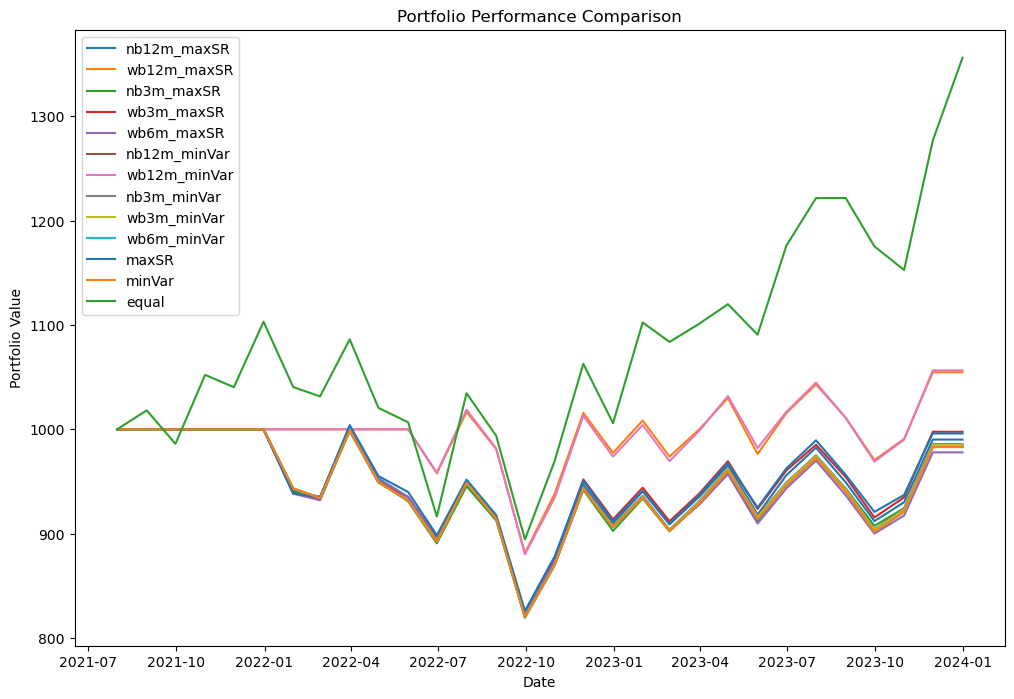

In [73]:
# Backtest portfolios
initial_capital = 1000
portfolios = weights_dict

# Perform backtest
results = {}
for name, weights in portfolios.items():
    results[name] = backtest(weights, actual_returns, initial_capital)

# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(returns.index, values, label=name)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### Performance Matrices

In [74]:
# Calculate cumulative returns
def calculate_cumulative_returns(portfolio_values):
    return (portfolio_values[-1] / portfolio_values[0]) - 1

# Calculate volatility
def calculate_volatility(portfolio_values):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    return np.std(returns) * np.sqrt(252)  # Annualized volatility

# Calculate Sharpe ratio
def calculate_sharpe_ratio(portfolio_values, risk_free_rate):
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    risk_free_rate = risk_free_rate.values.flatten()[:len(returns)]  # Ensure risk-free rate series matches returns length
    excess_returns = returns - risk_free_rate / 252
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)  # Annualized Sharpe ratio

# Calculate maximum drawdown
def calculate_max_drawdown(portfolio_values):
    peak = portfolio_values[0]
    max_drawdown = 0
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

In [75]:
# Calculate metrics for each portfolio
metrics = []
for name, values in results.items():
    cumulative_returns = calculate_cumulative_returns(values)
    volatility = calculate_volatility(values)
    sharpe_ratio = calculate_sharpe_ratio(values, risk_free_rate = risk_free_rate)
    max_drawdown = calculate_max_drawdown(values)
    metrics.append({
        'Portfolio': name,
        'Cumulative Returns': cumulative_returns,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)
metrics_df

,Portfolio,Cumulative Returns,Volatility,Sharpe Ratio,Max Drawdown
0,nb12m_maxSR,-0.009807,0.705691,0.232160,0.179367
1,wb12m_maxSR,0.054716,0.628093,1.053168,0.133186
2,nb3m_maxSR,-0.015546,0.703659,0.159065,0.180597
3,wb3m_maxSR,-0.002327,0.712935,0.328487,0.177572
4,wb6m_maxSR,-0.022073,0.705224,0.078200,0.177137
5,nb12m_minVar,-0.015213,0.704590,0.163992,0.180127
6,wb12m_minVar,0.056548,0.632847,1.073943,0.136132
7,nb3m_minVar,-0.014173,0.704748,0.177094,0.179564
8,wb3m_minVar,-0.015069,0.704511,0.165719,0.180019
9,wb6m_minVar,-0.016999,0.704858,0.141821,0.180103


### Re-backtest starting on the same date
It seems that the starting date actually matters. So let's start on the same date.

In [80]:
# Generate dynamic weights based on historical and predicted data
def generate_dynamic_weights(returns, pred_returns, cov_matrices, method, risk_free_rate, start_date):
    dates = returns.index
    tickers = returns.columns
    weights = pd.DataFrame(index=dates, columns=tickers).fillna(0)
    
    window = 6  # set rebalance window as 6 months
    start_date = pd.to_datetime(start_date)  # Convert start_date to Timestamp
    for i in range(window, len(dates)-1):  
        if dates[i] < start_date:
            continue
        past_data = returns.iloc[i-window:i]
        meanReturns = past_data.mean()
        covMatrix = cov_matrices[i]
        rf = risk_free_rate.iloc[i, 0]  # Select the first column's value
        pred_return_next_day = pred_returns.iloc[i+1]
        
        if method == 'max_sr':
            result = maxSR(meanReturns, covMatrix, rf)
        elif method == 'min_var':
            result = minimizeVariance(meanReturns, covMatrix)
        elif method == 'pred_max_sr':
            combined_mean_returns = 0.5 * meanReturns + 0.5 * pred_return_next_day  # to be clarified
            result = maxSR(combined_mean_returns, covMatrix, rf)
        elif method == 'pred_min_var':
            combined_mean_returns = 0.5 * meanReturns + 0.5 * pred_return_next_day  # to be clarified
            result = minimizeVariance(combined_mean_returns, covMatrix)        

        weights.iloc[i] = result.x
    return weights

# Backtest the portfolio
def backtest(weights, returns, initial_capital=1000, start_date='2022-06-30'):
    portfolio_values = [initial_capital]
    start_idx = returns.index.get_loc(start_date)
    for date in returns.index[start_idx + 1:]:
        prev_value = portfolio_values[-1]
        daily_return = np.sum(weights.loc[date] * returns.loc[date])
        portfolio_values.append(prev_value * (1 + daily_return))
    return portfolio_values

In [81]:
# Define models and weights dictionary
models_dict = {
    'nb12m': (pred_no_burning_window_12m, cov_matrices_12m_no_burning_window),
    'wb12m': (pred_with_burning_window_12m, cov_matrices_12m_with_burning_window),
    'nb3m': (pred_no_burning_window_3m, cov_matrices_3m_no_burning_window),
    'wb3m': (pred_with_burning_window_3m, cov_matrices_3m_with_burning_window),
    'wb6m': (pred_with_burning_window_6m, cov_matrices_6m_with_burning_window)
}

weights_dict = {}
start_date = '2022-06-30'

# Generate weights for each model prediction using MaxSR method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_max_sr', risk_free_rate=risk_free_rate, start_date=start_date)
    weights_dict[f'{model_name}_maxSR'] = weights
    print(f'Weights for "{model_name}_maxSR" model generated.')

# Generate weights for each model prediction using minVar method 
for model_name, (pred_returns, cov_matrices) in models_dict.items():
    weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='pred_min_var', risk_free_rate=risk_free_rate, start_date=start_date)
    weights_dict[f'{model_name}_minVar'] = weights
    print(f'Weights for "{model_name}_minVar" model generated.')

print(f'Weights generations done.')


Weights for "nb12m_maxSR" model generated.
Weights for "wb12m_maxSR" model generated.
Weights for "nb3m_maxSR" model generated.
Weights for "wb3m_maxSR" model generated.
Weights for "wb6m_maxSR" model generated.
Weights for "nb12m_minVar" model generated.
Weights for "wb12m_minVar" model generated.
Weights for "nb3m_minVar" model generated.
Weights for "wb3m_minVar" model generated.
Weights for "wb6m_minVar" model generated.
Weights generations done.


In [85]:
# Generate benchmark portfolio

# max_sr portfolio
max_sr_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='max_sr', risk_free_rate=risk_free_rate, start_date=start_date)
weights_dict["maxSR"] = max_sr_weights

# min var portfolio
min_var_weights = generate_dynamic_weights(returns, pred_returns, cov_matrices, method='min_var', risk_free_rate=risk_free_rate, start_date=start_date)
weights_dict["minVar"] = min_var_weights

# Equally weighted portfolio
equal_weights = pd.DataFrame(1/len(tickers), index=returns.index, columns=tickers)
weights_dict["equal"] = equal_weights

weights_dict.keys()

dict_keys(['nb12m_maxSR', 'wb12m_maxSR', 'nb3m_maxSR', 'wb3m_maxSR', 'wb6m_maxSR', 'nb12m_minVar', 'wb12m_minVar', 'nb3m_minVar', 'wb3m_minVar', 'wb6m_minVar', 'maxSR', 'minVar', 'equal'])

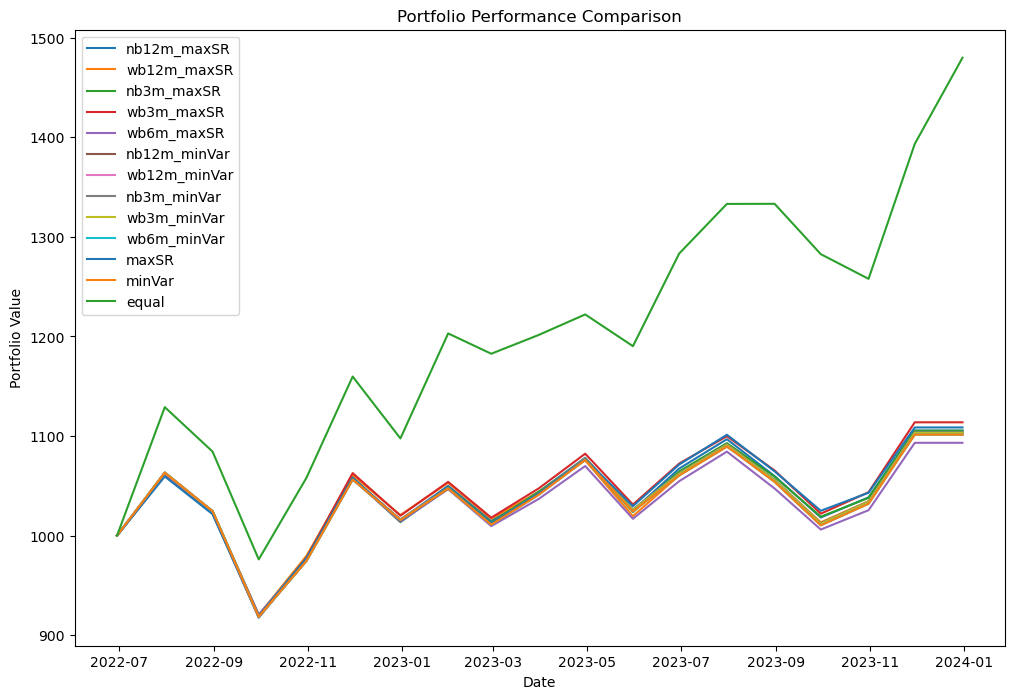

In [86]:
# Perform backtest
results = {}
for name, weights in weights_dict.items():
    results[name] = backtest(weights, actual_returns, initial_capital, start_date)

# Plot results
plt.figure(figsize=(12, 8))
for name, values in results.items():
    plt.plot(returns.loc[start_date:].index, values, label=name)
plt.title('Portfolio Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

In [87]:
# Calculate metrics for each portfolio
metrics = []
for name, values in results.items():
    cumulative_returns = calculate_cumulative_returns(values)
    volatility = calculate_volatility(values)
    sharpe_ratio = calculate_sharpe_ratio(values, risk_free_rate = risk_free_rate)
    max_drawdown = calculate_max_drawdown(values)
    metrics.append({
        'Portfolio': name,
        'Cumulative Returns': cumulative_returns,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    })

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics)
metrics_df

,Portfolio,Cumulative Returns,Volatility,Sharpe Ratio,Max Drawdown
0,nb12m_maxSR,0.105393,0.780665,2.195193,0.135231
1,wb12m_maxSR,0.101286,0.776171,2.135826,0.133186
2,nb3m_maxSR,0.105255,0.774421,2.204373,0.133359
3,wb3m_maxSR,0.113714,0.787839,2.315903,0.134889
4,wb6m_maxSR,0.093128,0.773286,2.005403,0.133113
5,nb12m_minVar,0.102923,0.782754,2.151254,0.136210
6,wb12m_minVar,0.102275,0.782917,2.140430,0.136132
7,nb3m_minVar,0.103643,0.783171,2.162233,0.136297
8,wb3m_minVar,0.103062,0.782659,2.153676,0.136219
9,wb6m_minVar,0.101450,0.782298,2.128000,0.135917


# Use below Data for Presentation Slides

In [24]:
# Lets first try to get the model to run for 1 stock
amzn = data[data['tic'] == 'AMZN'].iloc[:, :]
y = amzn['trt1m'].values
amzn.drop(columns=['trt1m'], inplace=True)
X = amzn.iloc[:, 2:].values
print(f"The Shape of X Features is: {X.shape}")
print(f"The Shape of y Features is: {y.shape}")

The Shape of X Features is: (154, 74)
The Shape of y Features is: (154,)


In [25]:
sequence_length = 12 # Feed past 12 month returns into sequence for LSTM
# Converting Features into 3D space for LSTM to add a time component
X_features, y_target = [], []
for i in range(X.shape[0] - sequence_length):
    X_features.append(X[i:i+sequence_length])
    y_target.append(y[i + sequence_length])
X_features = np.array(X_features)
y_target = np.array(y_target)

print(f"The Shape of X Features is: {X_features.shape}")
print(f"The Shape of y Features is: {y_target.shape}")

The Shape of X Features is: (142, 12, 74)
The Shape of y Features is: (142,)


In [26]:
train_size = int(len(amzn) * 0.8)
print(f"The size of my training set will be : {train_size} and the test set will be : {int(len(amzn)) - train_size}")
X_train, y_train = X_features[:train_size], y_target[:train_size]
y_train.reshape(-1, 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
X_test, y_test = X_features[train_size:], y_target[train_size:]
y_target.reshape(-1, 1)
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

The size of my training set will be : 123 and the test set will be : 31
Shape of X_train: (123, 12, 74)
Shape of y_train: (123,)
Shape of X_test: (19, 12, 74)
Shape of y_test: (19,)
